# Sarima model for temperatures in Brazil

## Collecting data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima

In [2]:
df = pd.read_csv('./data/GlobalLandTemperaturesByCountry.csv')

In [3]:
df.head(10)

,dt,AverageTemperature,AverageTemperatureUncertainty,Country
0,1743-11-01,4.384,2.294,Åland
1,1743-12-01,NaN,NaN,Åland
2,1744-01-01,NaN,NaN,Åland
3,1744-02-01,NaN,NaN,Åland
4,1744-03-01,NaN,NaN,Åland
5,1744-04-01,1.530,4.680,Åland
6,1744-05-01,6.702,1.789,Åland
7,1744-06-01,11.609,1.577,Åland
8,1744-07-01,15.342,1.410,Åland
9,1744-08-01,NaN,NaN,Åland


In [4]:
df.drop(columns = {'AverageTemperatureUncertainty'}, inplace= True)
df.head()

,dt,AverageTemperature,Country
0,1743-11-01,4.384,Åland
1,1743-12-01,NaN,Åland
2,1744-01-01,NaN,Åland
3,1744-02-01,NaN,Åland
4,1744-03-01,NaN,Åland


Let's collect only Brazil temperatures.

In [5]:
df = df[df['Country'] == 'Brazil']
df.head(10)

,dt,AverageTemperature,Country
77110,1832-01-01,24.935,Brazil
77111,1832-02-01,24.505,Brazil
77112,1832-03-01,24.617,Brazil
77113,1832-04-01,23.990,Brazil
77114,1832-05-01,23.124,Brazil
77115,1832-06-01,22.924,Brazil
77116,1832-07-01,22.974,Brazil
77117,1832-08-01,22.741,Brazil
77118,1832-09-01,23.560,Brazil
77119,1832-10-01,24.718,Brazil


In [6]:
df.drop(columns = {'Country'}, inplace = True)

## Understanding time series

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2181 entries, 77110 to 79290
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   dt                  2181 non-null   object 
 1   AverageTemperature  2164 non-null   float64
dtypes: float64(1), object(1)
memory usage: 51.1+ KB


We can see that for 2181 entries from 1832 to 2013 gives average temperature monthly.

And drop NaN values for temperature.

In [8]:
df = df.dropna()

In [9]:
df['dt'] = pd.to_datetime(df['dt'], format = "%Y-%m-%d")

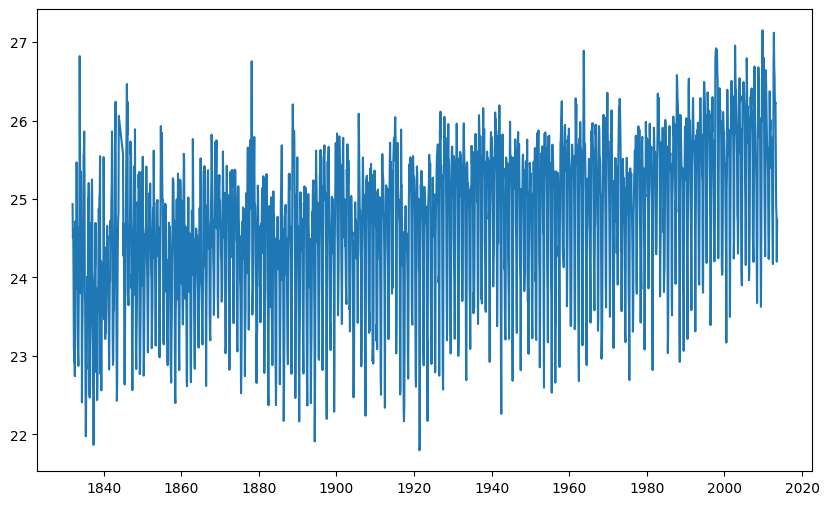

In [10]:
plt.figure(figsize=(10, 6), dpi=100)
plt.plot(df['dt'], df['AverageTemperature'])
plt.show()

In [11]:
df.dtypes

dt                    datetime64[ns]
AverageTemperature           float64
dtype: object

Check from 1832 to 1842 to find pattern.

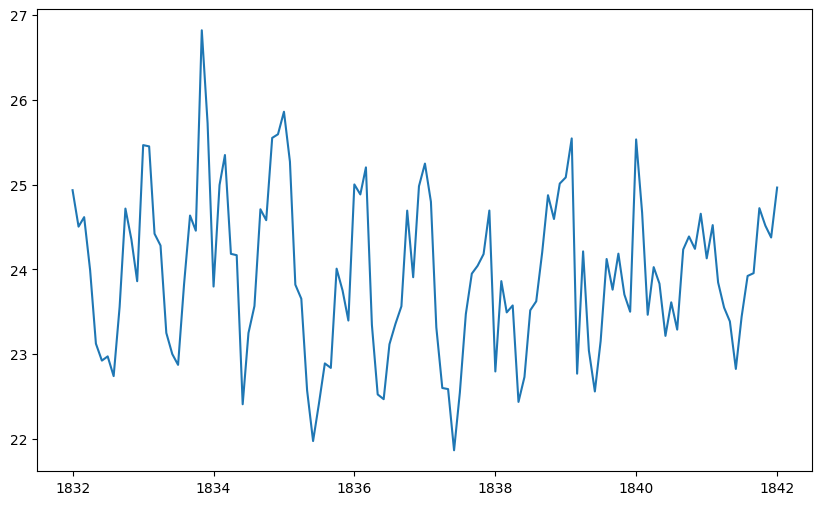

In [12]:
plt.figure(figsize=(10, 6), dpi=100)
plt.plot(df['dt'][df['dt'] <= '1842-01-01'], df['AverageTemperature'][df['dt'] <= '1842-01-01'])
plt.show()

We can see that there's sazonality of something around 10-12 months.

Setting the dt column as index.

In [13]:
df = df.set_index('dt')

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2164 entries, 1832-01-01 to 2013-08-01
Data columns (total 1 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   AverageTemperature  2164 non-null   float64
dtypes: float64(1)
memory usage: 33.8 KB


Decomposing the series to evaluate tendency for sazonality

In [15]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [16]:
plt.rcParams['figure.figsize'] = [14, 6]

<Figure size 1400x600 with 0 Axes>

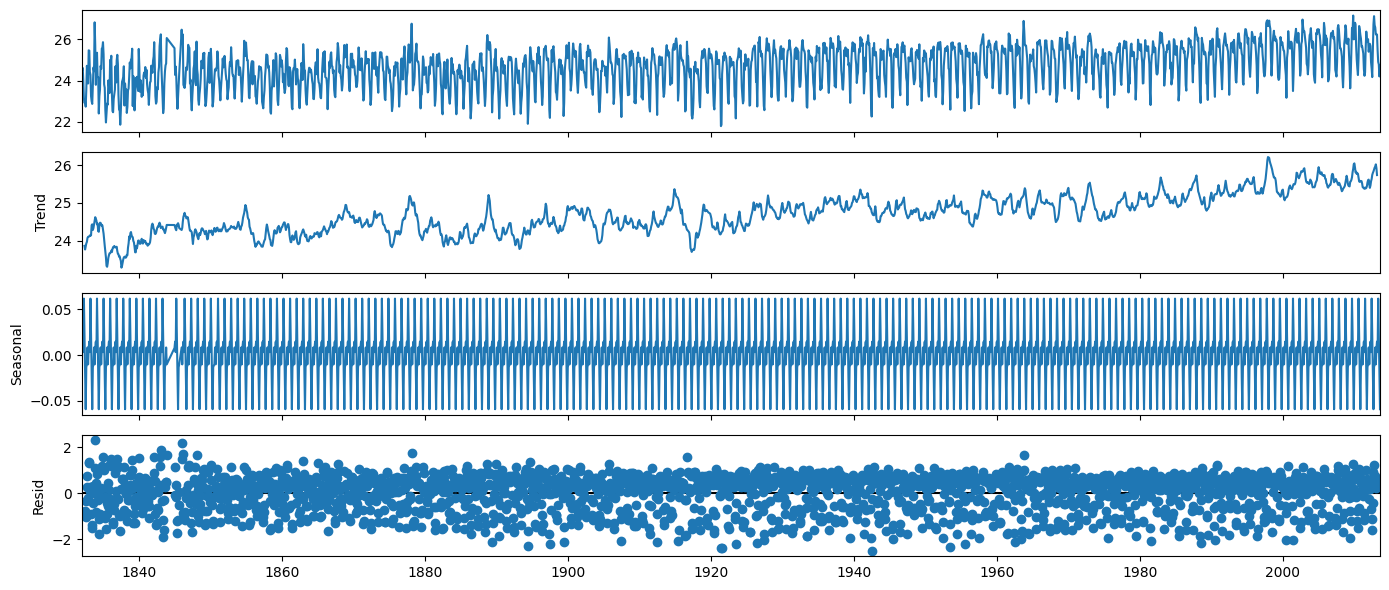

In [17]:
decompose = seasonal_decompose(df, model="add",period=11)

fig = plt.figure()  
fig = decompose.plot()

Stationarity test

In [18]:
# Hypothesis non stationary
from statsmodels.tsa.stattools import adfuller

test=adfuller(df['AverageTemperature'])
print(f'Test ADF:{test[0]}')
print(f'p-value:{test[1]}')

Test ADF:-3.012049316097817
p-value:0.03378436509413205


If P value greater than 5%, can't say the series are stationary. In this case, it indicates stationarity.

In [19]:
# Auto ARIMA using Akaike Information Criterion and stepwise
fit_arima = auto_arima(df, d=1, start_p=1, start_q=1, max_p=3, max_q=3,
                    seasonal=True, 
                           m=12, 
                           D=1, 
                           start_P=1, 
                           start_Q=1, 
                           max_P=2, 
                           max_Q=2, 
                           information_criterion='aic',
                           trace=True, # to print results
                           error_action='ignore', 
                           stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=inf, Time=6.12 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=4225.521, Time=0.08 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=3366.905, Time=0.45 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=2626.515, Time=0.71 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=3656.078, Time=0.14 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=2628.471, Time=0.89 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=2628.470, Time=2.05 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=3102.984, Time=0.59 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=2630.486, Time=3.00 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=3008.448, Time=0.81 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=3.19 sec
 ARIMA(0,1,2)(0,1,1)[12]             : AIC=2499.648, Time=0.84 sec
 ARIMA(0,1,2)(0,1,0)[12]             : AIC=3597.912, Time=0.32 sec
 ARIMA(0,1,2)(1,1,1)[12]             : AIC=2501.570, Time=1.51 sec
 ARIMA(0,1,2)(0,1,2)[12]     

Found the optimal parameters for the best model.

In [20]:
fit_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                 2164
Model:             SARIMAX(0, 1, 3)x(0, 1, [1], 12)   Log Likelihood               -1227.540
Date:                              Mon, 25 Mar 2024   AIC                           2465.080
Time:                                      11:12:50   BIC                           2493.448
Sample:                                           0   HQIC                          2475.458
                                             - 2164                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.5369      0.018    -29.135      0.000      -0.573      -0.501
ma.L2         -0.2209      0.020    -10.883      0.000      -0.261      -0.181
ma.L3         -0.1496      0.017     -8.600      0.000      -0.184      -0.115
ma.S.L12      -0.8446      0.010    -81.177      0.000      -0.865      -0.824
sigma2         0.1818      0.004     43.854      0.000       0.174       0.190
===================================================================================
Ljung-Box (L1) (Q):                   0.56   Jarque-Bera (JB):               264.12
Prob(Q):                              0.45   Prob(JB):                         0.00
Heteroskedasticity (H):               0.49   Skew:                            -0.18
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.68
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [22]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

#ARIMA(0,1,3)
#SARIMA(0,1,3)(0,1,1)[12] 

arima_model = SARIMAX(df,order=(0,1,3))
sarima_model = SARIMAX(df,order=(0,1,3), seasonal_order = (0,1,1,12))
result_arima = arima_model.fit()
result_sarima = sarima_model.fit()

C:\Users\Matheus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Matheus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Matheus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored wh

In [23]:
result_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:     AverageTemperature   No. Observations:                 2164
Model:               SARIMAX(0, 1, 3)   Log Likelihood               -1975.822
Date:                Mon, 25 Mar 2024   AIC                           3959.644
Time:                        11:14:35   BIC                           3982.361
Sample:                             0   HQIC                          3967.952
                               - 2164                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.1635      0.020     -8.093      0.000      -0.203      -0.124
ma.L2         -0.4104      0.018    -23.278      0.000      -0.445      -0.376
ma.L3         -0.4036      0.019    -21.268      0.000      -0.441      -0.366
sigma2         0.3633      0.011     34.600      0.000       0.343       0.384
===================================================================================
Ljung-Box (L1) (Q):                  17.86   Jarque-Bera (JB):                34.38
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.84   Skew:                            -0.25
Prob(H) (two-sided):                  0.02   Kurtosis:                         3.37
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [24]:
result_sarima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                   AverageTemperature   No. Observations:                 2164
Model:             SARIMAX(0, 1, 3)x(0, 1, [1], 12)   Log Likelihood               -1227.540
Date:                              Mon, 25 Mar 2024   AIC                           2465.080
Time:                                      11:14:45   BIC                           2493.448
Sample:                                           0   HQIC                          2475.458
                                             - 2164                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.5369      0.018    -29.135      0.000      -0.573      -0.501
ma.L2         -0.2209      0.020    -10.883      0.000      -0.261      -0.181
ma.L3         -0.1496      0.017     -8.600      0.000      -0.184      -0.115
ma.S.L12      -0.8446      0.010    -81.177      0.000      -0.865      -0.824
sigma2         0.1818      0.004     43.854      0.000       0.174       0.190
===================================================================================
Ljung-Box (L1) (Q):                   0.56   Jarque-Bera (JB):               264.12
Prob(Q):                              0.45   Prob(JB):                         0.00
Heteroskedasticity (H):               0.49   Skew:                            -0.18
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.68
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [25]:
predict_arima = result_arima.get_prediction(start=-60)
mean_prediction_arima = predict_arima.predicted_mean

predict_sarima = result_sarima.get_prediction(start=-60)
mean_prediction_sarima = predict_sarima.predicted_mean

In [26]:
confidence_interval_arima = predict_arima.conf_int()
lb_arima = confidence_interval_arima.iloc[:,0]
ub_arima = confidence_interval_arima.iloc[:,1]

lb_arima[0], ub_arima[0]

(24.793037211877, 27.155899024403148)

In [27]:
confidence_interval_sarima = predict_sarima.conf_int()
lb_sarima = confidence_interval_sarima.iloc[:,0]
ub_sarima = confidence_interval_sarima.iloc[:,1]

lb_sarima[0], ub_sarima[0]

(25.45684269263358, 27.12839531022943)

In [28]:
mean_prediction_arima[0]

25.974468118140074

In [29]:
mean_prediction_sarima[0]

26.292619001431504

In [30]:
dates_prediction_arima = np.asarray(mean_prediction_arima.index)
dates_prediction_sarima = np.asarray(mean_prediction_sarima.index)
dates = np.asarray(df.index)

Plot ARIMA model

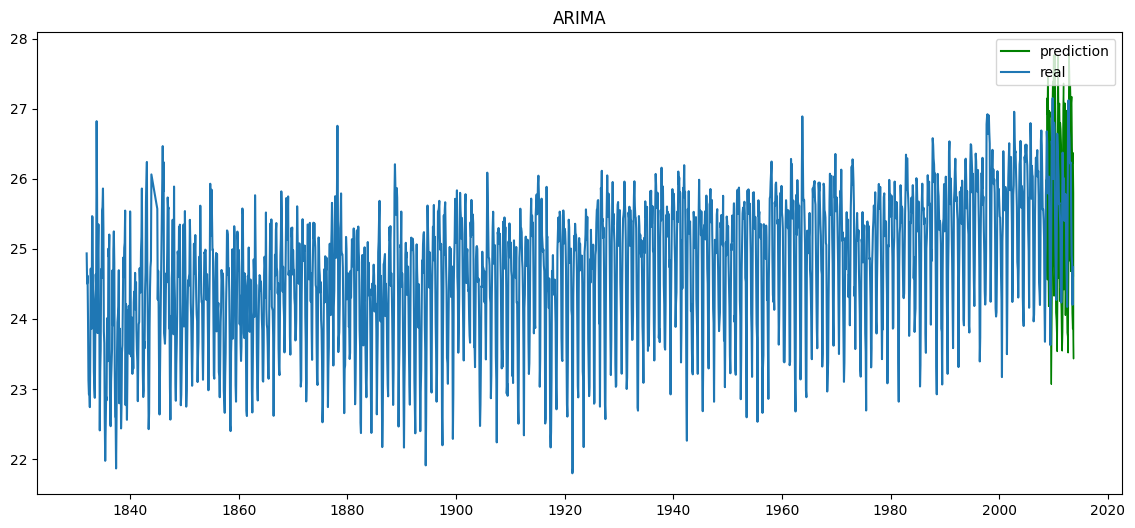

In [31]:
plt.plot(dates_prediction_arima,mean_prediction_arima.values,color='green',label='prediction')
plt.fill_between(dates_prediction_arima, lb_arima, ub_arima, color='green')
plt.plot(dates, df.values, label='real')
plt.legend()
plt.title('ARIMA')
plt.show()

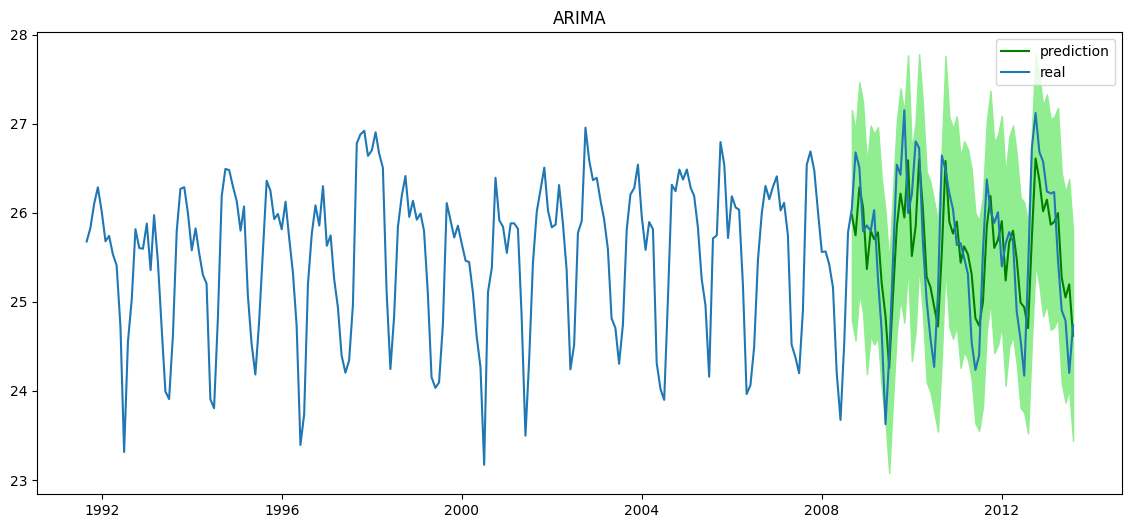

In [45]:
plt.plot(dates_prediction_arima,mean_prediction_arima.values,color='green',label='prediction')
plt.fill_between(dates_prediction_arima, lb_arima, ub_arima, color='lightgreen')
plt.plot(dates[1900:], df.values[1900:], label='real')
plt.legend()
plt.title('ARIMA')
plt.show()

In [72]:
from sklearn.metrics import mean_absolute_error

mae_arima = mean_absolute_error(df[-60:], mean_prediction_arima.values)
print(f"MAE ARIMA model: {mae_arima}")

MAE ARIMA model: 0.45010442563434927


Plot SARIMA model

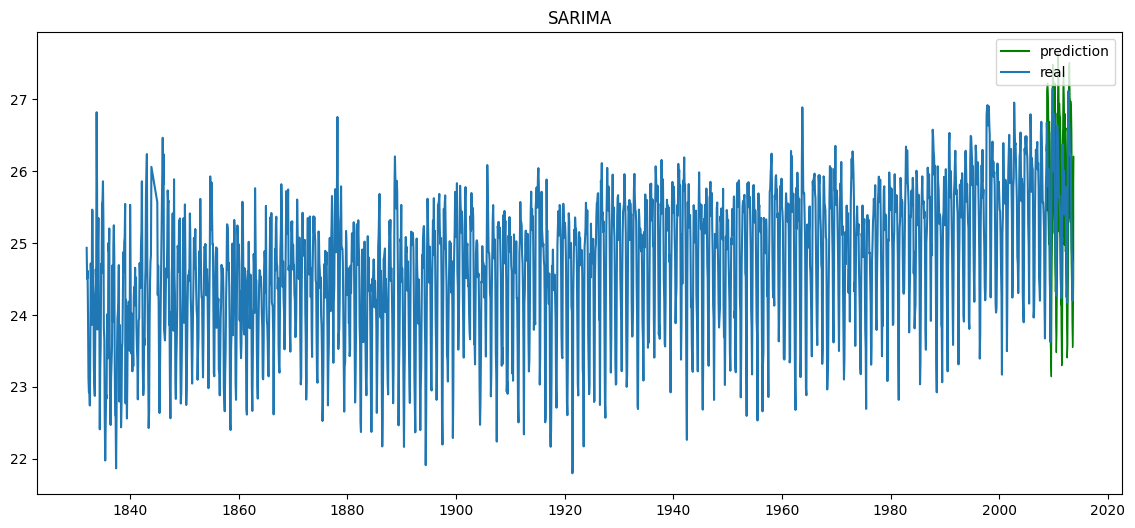

In [46]:
plt.plot(dates_prediction_sarima,mean_prediction_sarima.values,color='green',label='prediction')
plt.fill_between(dates_prediction_sarima, lb_sarima, ub_sarima, color='green')
plt.plot(dates, df.values, label='real')
plt.legend()
plt.title('SARIMA')
plt.show()

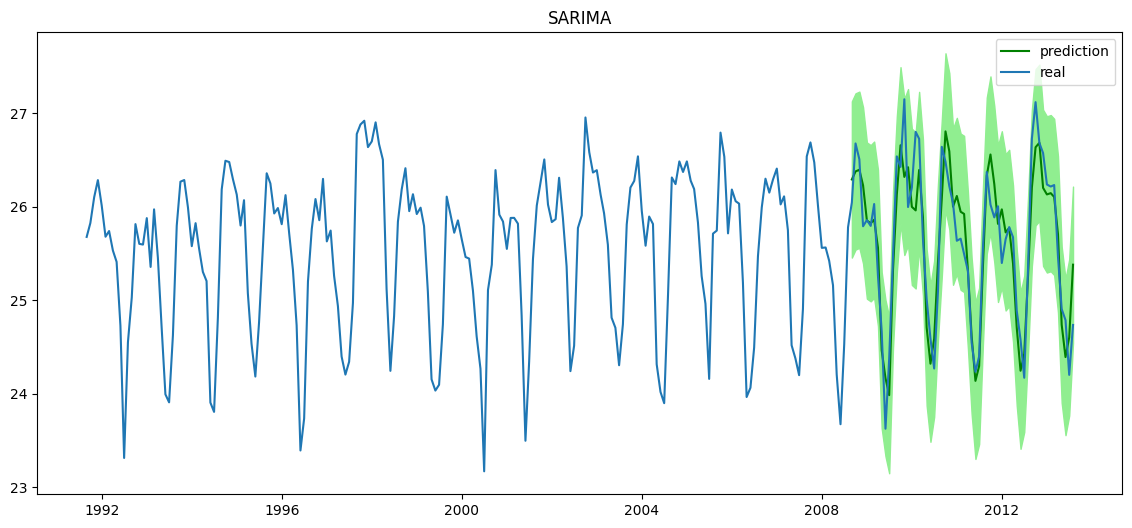

In [164]:
plt.plot(dates_prediction_sarima,mean_prediction_sarima.values,color='green',label='prediction')
plt.fill_between(dates_prediction_sarima, lb_sarima, ub_sarima, color='lightgreen')
plt.plot(dates[1900:], df.values[1900:], label='real')
plt.legend()
plt.title('SARIMA')
plt.show()

In [73]:
mae_sarima = mean_absolute_error(df[-60:], mean_prediction_sarima.values)
print(f"MAE SARIMA model: {mae_sarima}")

MAE SARIMA model: 0.2830905966271411


Forecast with SARIMA model

In [176]:
forecast = result_sarima.get_forecast(steps = 20) # months ahead
forecast_medio = forecast.predicted_mean
forecast_medio.size

C:\Users\Matheus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Matheus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


20

In [177]:
intervalo_confianca_forecast = forecast.conf_int()
lower_bound_fore = intervalo_confianca_forecast.iloc[:,0]
upper_bound_fore = intervalo_confianca_forecast.iloc[:,1]
datas_forecast = np.asarray(forecast_medio.index)

In [178]:
from datetime import date
from dateutil.relativedelta import relativedelta

dates_forecast = []

for index in datas_forecast:
    #print(date(2013, 9, 1) + relativedelta(months=index-2163))
    dates_forecast.append(date(2013, 9, 1) + relativedelta(months=index-2163))

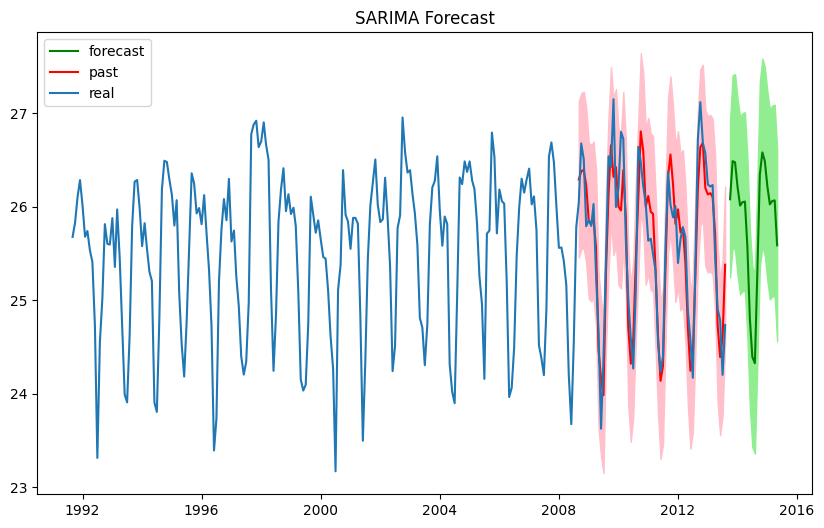

In [179]:
plt.figure(figsize=(10,6))
plt.plot(dates_forecast, forecast_medio, color = "green", label = "forecast")
plt.fill_between(dates_forecast, lower_bound_fore, upper_bound_fore, color = "lightgreen")

plt.plot(dates_prediction_sarima,mean_prediction_sarima.values, color = "red", label = "past")
plt.fill_between(dates_prediction_sarima, lb_sarima, ub_sarima, color = "pink")

plt.plot(dates[1900:], df.values[1900:], label = "real")
plt.title('SARIMA Forecast')
plt.legend()
plt.show()